<a href="https://colab.research.google.com/github/ArwaSaif99/weather_app/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RATING DISTRIBUTION

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

ratings = pd.read_csv('ratings.csv', sep=',', on_bad_lines='warn')

ratings_per_user = Counter(ratings['userId'])
ratings_per_movie = Counter(ratings['movieId'])

user_rating_distribution = Counter(ratings_per_user.values())
movie_rating_distribution = Counter(ratings_per_movie.values())

user_rating_counts = list(user_rating_distribution.keys())
user_count_frequency = list(user_rating_distribution.values())

movie_rating_counts = list(movie_rating_distribution.keys())
movie_count_frequency = list(movie_rating_distribution.values())


# **log-log scale scatter plot**

# Plot for Users

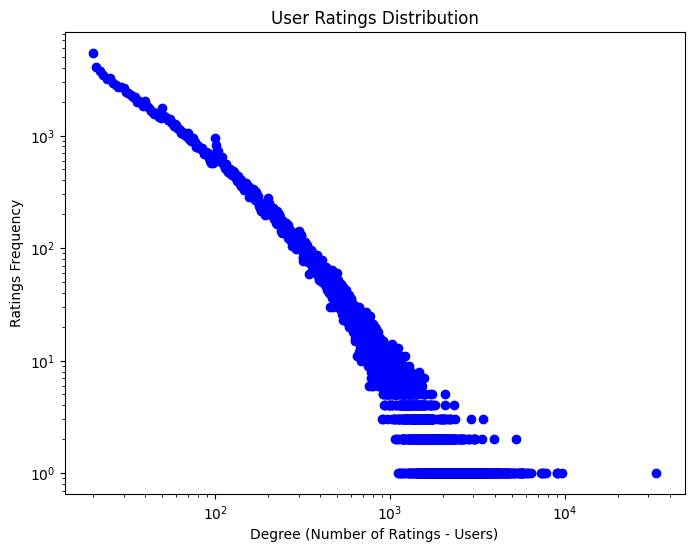

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(user_rating_counts, user_count_frequency, marker='o', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (Number of Ratings - Users)')
plt.ylabel('Ratings Frequency')
plt.title('User Ratings Distribution')
plt.savefig('user_ratings_log-log.pdf', format='pdf')
plt.show()

# Plot for Movies

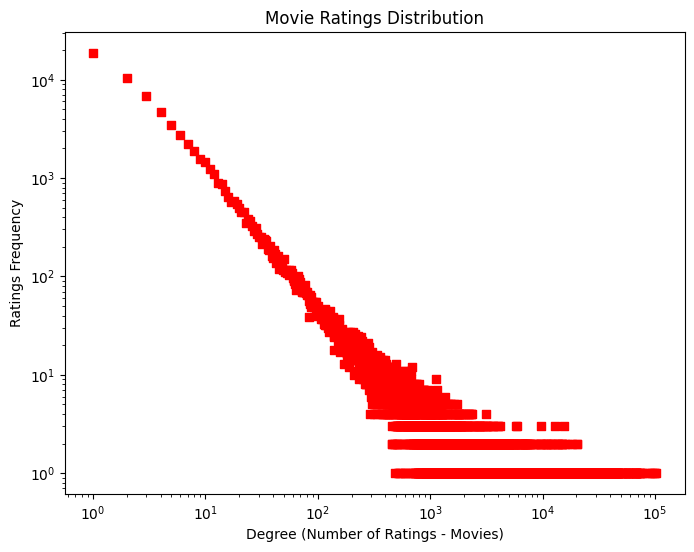

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(movie_rating_counts, movie_count_frequency, marker='s', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (Number of Ratings - Movies)')
plt.ylabel('Ratings Frequency')
plt.title('Movie Ratings Distribution')
plt.savefig('movie_ratings_log-log.pdf', format='pdf')
plt.show()

# Combined Plot

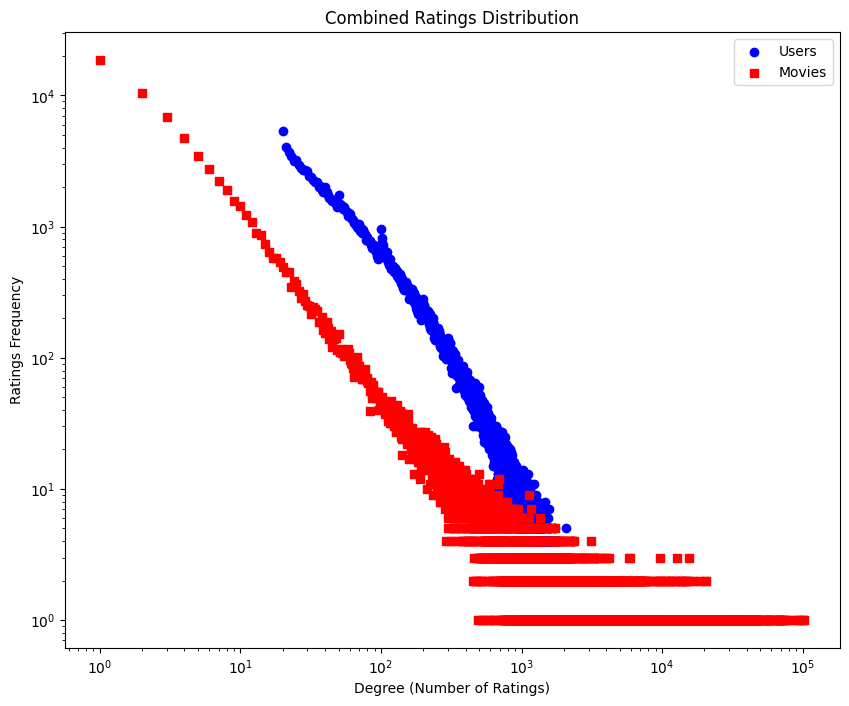

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(user_rating_counts, user_count_frequency, marker='o', color='blue', label='Users')
plt.scatter(movie_rating_counts, movie_count_frequency, marker='s', color='red', label='Movies')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (Number of Ratings)')
plt.ylabel('Ratings Frequency')
plt.legend()
plt.title('Combined Ratings Distribution')
plt.savefig('combined_log-log.pdf', format='pdf')
plt.show()

# **Biases Only**

In [ ]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import List, Tuple, Dict

def create_user_movie_mappings(ratings_df):

    user_to_idx = {}
    movie_to_idx = {}
    idx_to_user = []
    idx_to_movie = []

    for row in ratings_df.itertuples():
        user_id = row.userId
        movie_id = row.movieId

        if user_id not in user_to_idx:
            user_idx = len(user_to_idx)
            user_to_idx[user_id] = user_idx
            idx_to_user.append(user_id)

        if movie_id not in movie_to_idx:
            movie_idx = len(movie_to_idx)
            movie_to_idx[movie_id] = movie_idx
            idx_to_movie.append(movie_id)

    return user_to_idx, movie_to_idx, idx_to_user, idx_to_movie

def organize_ratings(ratings_df, user_to_idx, movie_to_idx):
    ratings_by_user = []
    for i in range(len(user_to_idx)):
        ratings_by_user.append([])

    ratings_by_movie = []
    for j in range(len(movie_to_idx)):
        ratings_by_movie.append([])

    for row in ratings_df.itertuples():
        user_id = row.userId
        movie_id = row.movieId
        user_idx = user_to_idx[user_id]
        movie_idx = movie_to_idx[movie_id]
        rating = row.rating
        ratings_by_user[user_idx].append((movie_idx, rating))
        ratings_by_movie[movie_idx].append((user_idx, rating))

    return ratings_by_user, ratings_by_movie


def split_ratings(ratings, train_ratio: float = 0.8) :

    train_set = []
    test_set = []
    for user_ratings in ratings:
        split_index = int(len(user_ratings) * train_ratio)
        train_set.append(user_ratings[:split_index])
        test_set.append(user_ratings[split_index:])
    return train_set, test_set

def plot_metrics(train_rmse, test_rmse, train_loss, test_loss,
                          rmse_save_path: str = 'rmse_plot.pdf',
                          loss_save_path: str = 'loss_plot.pdf'):
    plt.figure(figsize=(6, 5))
    plt.plot(range(1, len(train_rmse) + 1), train_rmse, 'b-', label='Train RMSE')
    plt.plot(range(1, len(test_rmse) + 1), test_rmse, 'r-', label='Test RMSE')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Iteration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(rmse_save_path)
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(range(1, len(train_loss) + 1), train_loss, 'b-', label='Train Loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, 'r-', label='Test Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs Iteration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(loss_save_path)
    plt.show()


In [ ]:


def calculate_bias_only_loss(train_ratings, biases_user,
                           biases_movie) :

    total_loss = 0
    for user_index, user_ratings in enumerate(train_ratings):
        for movie_index, actual_rating in user_ratings:
            predicted_rating = biases_user[user_index] + biases_movie[movie_index]
            rating_error = actual_rating - predicted_rating
            total_loss += rating_error ** 2
    return total_loss

def calculate_bias_only_rmse(training_ratings, user_biases,
                           movie_biases):

    total_squared_error = 0
    total_count = 0

    for user_index, user_ratings in enumerate(training_ratings):
        for movie_index, actual_rating in user_ratings:
            predicted_rating = user_biases[user_index] + movie_biases[movie_index]
            error = actual_rating - predicted_rating
            total_squared_error += error ** 2
            total_count += 1

    rmse = np.sqrt(total_squared_error / total_count) if total_count > 0 else 0
    return rmse

def update_bias_only_user_biases(ratings, user_biases,
                               movie_biases, lambda_) :

    for user_index in range(len(ratings)):
        bias_sum = 0
        count_ratings = 0
        for movie_index, rating in ratings[user_index]:
            bias_sum += rating - movie_biases[movie_index]
            count_ratings += 1
        if count_ratings > 0:
            user_biases[user_index] = bias_sum / (count_ratings + lambda_)

def update_bias_only_movie_biases(ratings, user_biases,
                                movie_biases, lambda_) :

    for movie_index in range(len(ratings)):
        bias_sum = 0
        count_ratings = 0
        for user_index, rating in ratings[movie_index]:
            bias_sum += rating - user_biases[user_index]
            count_ratings += 1
        if count_ratings > 0:
            movie_biases[movie_index] = bias_sum / (count_ratings + lambda_)

def train_bias_only_model(ratings_by_users_train, ratings_by_users_test,
                         ratings_by_movies, n_users, n_movies,
                         lambda_, iterations) :

    movie_biases = np.zeros(n_movies)
    user_biases = np.zeros(n_users)

    train_loss = []
    test_loss = []
    train_rmse = []
    test_rmse = []

    for iteration in range(iterations):
        update_bias_only_user_biases(ratings_by_users_train, user_biases, movie_biases, lambda_)
        update_bias_only_movie_biases(ratings_by_movies, user_biases, movie_biases, lambda_)

        train_loss_value = calculate_bias_only_loss(ratings_by_users_train, user_biases, movie_biases)
        test_loss_value = calculate_bias_only_loss(ratings_by_users_test, user_biases, movie_biases)
        train_rmse_value = calculate_bias_only_rmse(ratings_by_users_train, user_biases, movie_biases)
        test_rmse_value = calculate_bias_only_rmse(ratings_by_users_test, user_biases, movie_biases)

        train_loss.append(train_loss_value)
        test_loss.append(test_loss_value)
        train_rmse.append(train_rmse_value)
        test_rmse.append(test_rmse_value)

        print(f"Iteration {iteration + 1}:")
        print(f"Iteration {iteration + 1}: Train Loss = {train_loss_value:.8f}, "f"Test Loss = {test_loss_value:.8f}, Train RMSE = {train_rmse_value:.8f}, "f"Test RMSE = {test_rmse_value:.8f}")


    return user_biases, movie_biases, train_loss, test_loss, train_rmse, test_rmse

In [ ]:



def calculate_mf_loss(train_ratings, biases_user, biases_movie,
                     vectors_user, vectors_movie) :

    total_loss = 0
    for user_index, user_ratings in enumerate(train_ratings):
        for movie_index, actual_rating in user_ratings:
            predicted_rating = (np.dot(vectors_user[user_index], vectors_movie[movie_index]) +
                              biases_user[user_index] + biases_movie[movie_index])
            rating_error = actual_rating - predicted_rating
            total_loss += rating_error ** 2
    return total_loss

def calculate_mf_rmse(training_ratings, user_biases, movie_biases,
                     user_vectors, movie_vectors):

    total_squared_error = 0
    total_count = 0
    for user_index, user_ratings in enumerate(training_ratings):
        for movie_index, actual_rating in user_ratings:
            predicted_rating = (np.dot(user_vectors[user_index], movie_vectors[movie_index]) +
                              user_biases[user_index] + movie_biases[movie_index])
            error = actual_rating - predicted_rating
            total_squared_error += error ** 2
            total_count += 1
    rmse = np.sqrt(total_squared_error / total_count) if total_count > 0 else 0
    return rmse

def update_mf_user_biases(ratings, user_vectors, movie_vectors,
                         movie_biases, user_biases, lambda_) -> None:

    for user_index in range(len(ratings)):
        bias_sum = 0
        count_ratings = 0
        for movie_index, rating in ratings[user_index]:
            bias_sum += (rating - movie_biases[movie_index] -
                        np.dot(user_vectors[user_index], movie_vectors[movie_index]))
            count_ratings += 1
        if count_ratings > 0:
            user_biases[user_index] = bias_sum / (count_ratings + lambda_)

def update_mf_user_latent_factors(ratings, user_vectors, movie_vectors,
                                movie_biases, user_biases,
                                tau, k, lambda_) :

    for user_index in range(len(ratings)):
        rated_movies = [entry for entry in ratings[user_index] if entry[1] != 0]
        if rated_movies:
            movie_indices = [movie for movie, _ in rated_movies]
            V_T_V = np.dot(movie_vectors[movie_indices].T, movie_vectors[movie_indices]) + tau * np.eye(k)
            right_hand_side = np.dot(movie_vectors[movie_indices].T,
                                   [rating - movie_biases[movie] - user_biases[user_index]
                                    for movie, rating in rated_movies])
            user_vectors[user_index] = np.linalg.solve(V_T_V + lambda_ * np.eye(k), right_hand_side)

def update_mf_movie_biases(ratings, user_vectors, movie_vectors,
                          user_biases, movie_biases, lambda_) :

    for movie_index in range(len(ratings)):
        bias_sum = 0
        count_ratings = 0
        for user_index, rating in ratings[movie_index]:
            bias_sum += (rating - user_biases[user_index] -
                        np.dot(user_vectors[user_index], movie_vectors[movie_index]))
            count_ratings += 1
        if count_ratings > 0:
            movie_biases[movie_index] = bias_sum / (count_ratings + lambda_)

def update_mf_movie_latent_factors(ratings, user_vectors, movie_vectors,
                                 user_biases, movie_biases,
                                 tau, k, lambda_) :

    for movie_index in range(len(ratings)):
        rated_users = [entry for entry in ratings[movie_index] if entry[1] != 0]
        if rated_users:
            user_indices = [user for user, _ in rated_users]
            U_T_U = np.dot(user_vectors[user_indices].T, user_vectors[user_indices]) + tau * np.eye(k)
            right_hand_side = np.dot(user_vectors[user_indices].T,
                                   [rating - user_biases[user] - movie_biases[movie_index]
                                    for user, rating in rated_users])
            movie_vectors[movie_index] = np.linalg.solve(U_T_U + lambda_ * np.eye(k), right_hand_side)

def train_matrix_factorization_model(ratings_by_users_train, ratings_by_users_test,
                                   ratings_by_movies_train, n_users, n_movies,
                                   k = 32, lambda_ = 0.5, tau = 5,
                                   iterations = 10):

    movie_biases = np.zeros(n_movies)
    user_biases = np.zeros(n_users)
    user_vectors = np.random.uniform(0, 1/np.sqrt(k), (n_users, k))
    movie_vectors = np.random.uniform(0, 1/np.sqrt(k), (n_movies, k))

    train_loss = []
    test_loss = []
    train_rmse = []
    test_rmse = []

    for iteration in range(iterations):
        update_mf_user_biases(ratings_by_users_train, user_vectors, movie_vectors,
                            movie_biases, user_biases, lambda_)
        update_mf_user_latent_factors(ratings_by_users_train, user_vectors, movie_vectors,
                                    movie_biases, user_biases, tau, k, lambda_)
        update_mf_movie_biases(ratings_by_movies_train, user_vectors, movie_vectors,
                             user_biases, movie_biases, lambda_)
        update_mf_movie_latent_factors(ratings_by_movies_train, user_vectors, movie_vectors,
                                     user_biases, movie_biases, tau, k, lambda_)

        train_loss_value = calculate_mf_loss(ratings_by_users_train, user_biases,
                                           movie_biases, user_vectors, movie_vectors)
        test_loss_value = calculate_mf_loss(ratings_by_users_test, user_biases,
                                          movie_biases, user_vectors, movie_vectors)
        train_rmse_value = calculate_mf_rmse(ratings_by_users_train, user_biases,
                                           movie_biases, user_vectors, movie_vectors)
        test_rmse_value = calculate_mf_rmse(ratings_by_users_test, user_biases,
                                          movie_biases, user_vectors, movie_vectors)

        train_loss.append(train_loss_value)
        test_loss.append(test_loss_value)
        train_rmse.append(train_rmse_value)
        test_rmse.append(test_rmse_value)

        print(f"Iteration {iteration + 1}:")
        print(f" Train Loss = {train_loss_value:.8f}, "
      f"Test Loss = {test_loss_value:.8f}, Train RMSE = {train_rmse_value:.8f}, "
      f"Test RMSE = {test_rmse_value:.8f}")


    return (user_biases, movie_biases, user_vectors, movie_vectors,
            train_loss, test_loss, train_rmse, test_rmse)

In [ ]:
ratings_df = pd.read_csv('ratings.csv', sep=',', on_bad_lines='warn')

user_to_idx, movie_to_idx, idx_to_user, idx_to_movie = create_user_movie_mappings(ratings_df)

ratings_by_user, ratings_by_movie = organize_ratings(ratings_df, user_to_idx, movie_to_idx)

ratings_by_users_train, ratings_by_users_test = split_ratings(ratings_by_user)
ratings_by_movies_train, ratings_by_movies_test = split_ratings(ratings_by_movie)

n_users = len(user_to_idx)
n_movies = len(movie_to_idx)

Training Bias-Only Model...
Iteration 1:
Iteration 1: Train Loss = 18838439.16194798, Test Loss = 5184369.65716441, Train RMSE = 0.85916087, Test RMSE = 0.89450691
Iteration 2:
Iteration 2: Train Loss = 18167906.94966184, Test Loss = 4968657.53717780, Train RMSE = 0.84373192, Test RMSE = 0.87569981
Iteration 3:
Iteration 3: Train Loss = 18136315.80671901, Test Loss = 4951669.89654051, Train RMSE = 0.84299804, Test RMSE = 0.87420153
Iteration 4:
Iteration 4: Train Loss = 18134655.62116819, Test Loss = 4948715.70388099, Train RMSE = 0.84295946, Test RMSE = 0.87394072
Iteration 5:
Iteration 5: Train Loss = 18134653.56506743, Test Loss = 4947811.87020802, Train RMSE = 0.84295941, Test RMSE = 0.87386090
Iteration 6:
Iteration 6: Train Loss = 18134718.19341845, Test Loss = 4947438.63893725, Train RMSE = 0.84296091, Test RMSE = 0.87382794
Iteration 7:
Iteration 7: Train Loss = 18134753.36611996, Test Loss = 4947248.51540476, Train RMSE = 0.84296173, Test RMSE = 0.87381115
Iteration 8:
Iterati

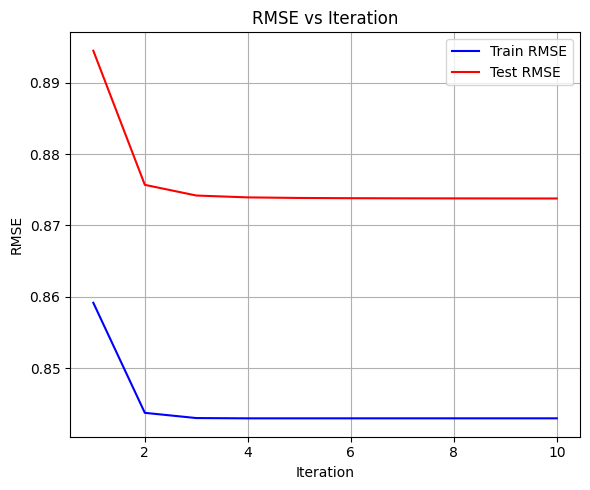

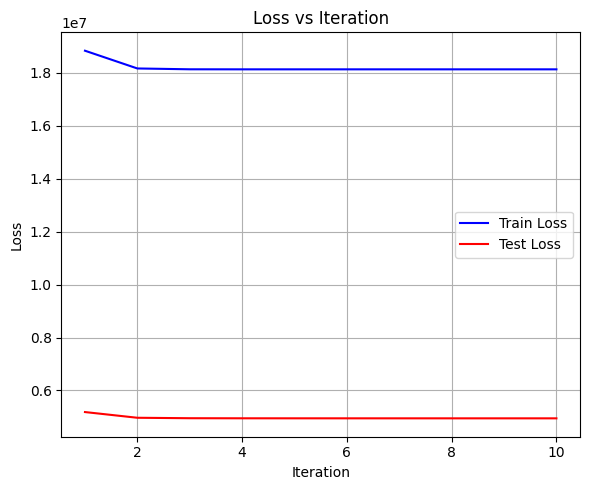

In [ ]:
print("Training Bias-Only Model...")
(user_biases_simple, movie_biases_simple,
 train_loss_simple, test_loss_simple,
 train_rmse_simple, test_rmse_simple) = train_bias_only_model(
    ratings_by_users_train=ratings_by_users_train,
    ratings_by_users_test=ratings_by_users_test,
    ratings_by_movies=ratings_by_movies_train,
    n_users=n_users,
    n_movies=n_movies,
    lambda_=0.01,
    iterations=10
)

plot_metrics(
    train_rmse=train_rmse_simple,
    test_rmse=test_rmse_simple,
    train_loss=train_loss_simple,
    test_loss=test_loss_simple,
    rmse_save_path='bias_only_rmse.pdf',
    loss_save_path='bias_only_loss.pdf'
)


Training Matrix Factorization Model...
Iteration 1:
 Train Loss = 16068918.84543671, Test Loss = 4928684.50309088, Train RMSE = 0.79349713, Test RMSE = 0.87217017
Iteration 2:
 Train Loss = 11310507.36677843, Test Loss = 4256921.03706601, Train RMSE = 0.66572226, Test RMSE = 0.81055692
Iteration 3:
 Train Loss = 10544408.29486162, Test Loss = 4121193.89660350, Train RMSE = 0.64278116, Test RMSE = 0.79753040
Iteration 4:
 Train Loss = 10201564.13505647, Test Loss = 4071012.85505191, Train RMSE = 0.63224502, Test RMSE = 0.79266003
Iteration 5:
 Train Loss = 10007419.67514095, Test Loss = 4047583.86099579, Train RMSE = 0.62620004, Test RMSE = 0.79037583
Iteration 6:
 Train Loss = 9884326.40096265, Test Loss = 4035140.33239479, Train RMSE = 0.62233693, Test RMSE = 0.78915996
Iteration 7:
 Train Loss = 9800572.36846641, Test Loss = 4027971.85870043, Train RMSE = 0.61969466, Test RMSE = 0.78845867
Iteration 8:
 Train Loss = 9740705.90838581, Test Loss = 4023671.11510581, Train RMSE = 0.61779

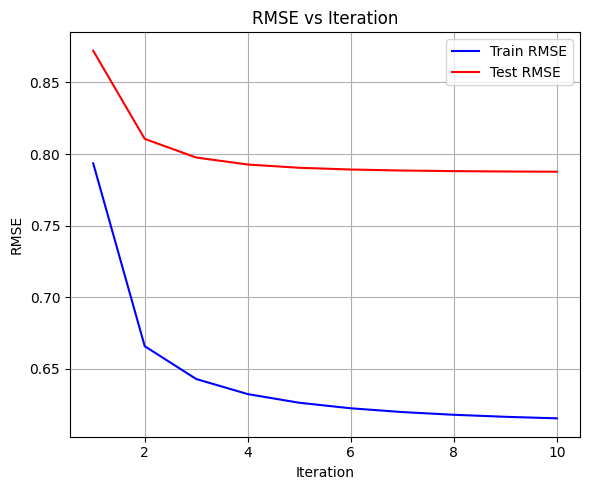

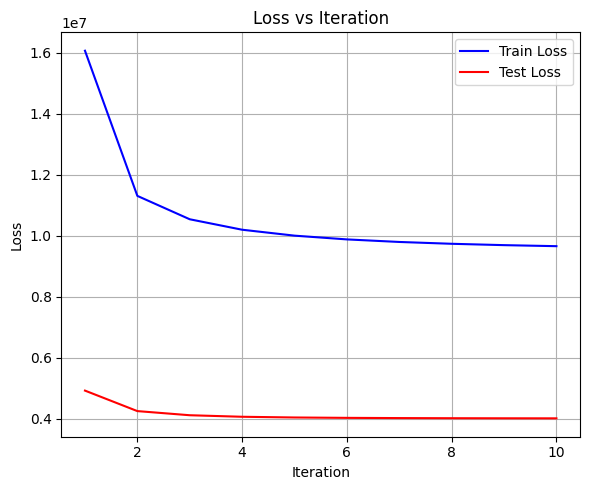

In [ ]:
print("Training Matrix Factorization Model...")
(user_biases_mf, movie_biases_mf,
 user_vectors, movie_vectors,
 train_loss_mf, test_loss_mf,
 train_rmse_mf, test_rmse_mf) = train_matrix_factorization_model(
    ratings_by_users_train=ratings_by_users_train,
    ratings_by_users_test=ratings_by_users_test,
    ratings_by_movies_train=ratings_by_movies_train,
    n_users=n_users,
    n_movies=n_movies,
    k=32,
    lambda_=0.5,
    tau=5,
    iterations=10
)
plot_metrics(
    train_rmse=train_rmse_mf,
    test_rmse=test_rmse_mf,
    train_loss=train_loss_mf,
    test_loss=test_loss_mf,
    rmse_save_path='matrix_factorization_rmse.pdf',
    loss_save_path='matrix_factorization_loss.pdf'
)

Final Metrics Comparison:

Bias-Only Model:
Final Train RMSE: 0.8430
Final Test RMSE: 0.8738

Matrix Factorization Model:
Final Train RMSE: 0.6153
Final Test RMSE: 0.7876


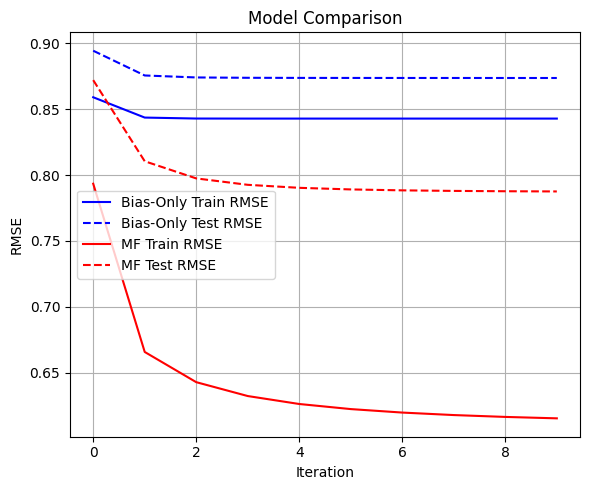

In [ ]:
print("Final Metrics Comparison:")
print("\nBias-Only Model:")
print(f"Final Train RMSE: {train_rmse_simple[-1]:.4f}")
print(f"Final Test RMSE: {test_rmse_simple[-1]:.4f}")

print("\nMatrix Factorization Model:")
print(f"Final Train RMSE: {train_rmse_mf[-1]:.4f}")
print(f"Final Test RMSE: {test_rmse_mf[-1]:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(train_rmse_simple, 'b-', label='Bias-Only Train RMSE')
plt.plot(test_rmse_simple, 'b--', label='Bias-Only Test RMSE')
plt.plot(train_rmse_mf, 'r-', label='MF Train RMSE')
plt.plot(test_rmse_mf, 'r--', label='MF Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Model Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('model_comparison.pdf')
plt.show()

In [ ]:
lambda_ = 0.5
gamma = 0.5
tau = 5
iterations = 10
k = 32



movie_data = pd.read_csv('movies.csv')

from typing import Optional
import pandas as pd

def search_movie_id(query,
                   movie_data,
                   movie_to_idx) :

    try:
        matches = movie_data[movie_data['title'].str.lower().str.contains(
            query.lower(),
            regex=False,
            na=False
        )]

        if not matches.empty:
            movie_id = matches.iloc[0]['movieId']
            return movie_to_idx.get(movie_id, None)

        return None

    except (AttributeError, KeyError) as e:
        print(f"Error searching for movie: {e}")
        return None
def adjust_profile(vector,
                  bias,
                  ratings,
                  movie_vectors,
                  movie_biases,
                  k,
                  lambda_,
                  tau) :

    bias_total = sum(rating - movie_biases[movie] - np.dot(vector, movie_vectors[movie])
                    for movie, rating in ratings)
    if ratings:
        bias = bias_total / (len(ratings) + lambda_)

    for movie, rating in ratings:
        adjustment = np.dot(movie_vectors[movie].T, movie_vectors[movie]) + tau * np.eye(k)
        target = movie_vectors[movie] * (rating - movie_biases[movie] - bias)
        vector = np.linalg.solve(adjustment + lambda_ * np.eye(k), target)

    return vector, bias

def recommend_movies(vector,
                    bias,
                    movie_vectors,
                    movie_biases,
                    id_to_movie,
                    movie_data,
                    exclude_idx,
                    top_n: int = 10) :

    scored_movies = [
        (idx, np.dot(vector, movie_vectors[idx]) + 0.05 * movie_biases[idx] + bias)
        for idx in range(len(movie_vectors))
        if idx != exclude_idx
    ]

    top_choices = sorted(scored_movies, key=lambda x: x[1], reverse=True)[:top_n]
    return [(id_to_movie[movie_id], score) for movie_id, score in top_choices]


id_to_movie = idx_to_movie

def get_recommendations_for_movie(title_query,
                                rating,
                                top_n: int = 10) :

    movie_idx = search_movie_id(title_query, movie_data, movie_to_idx)

    if movie_idx is not None:
        profile_vector = np.zeros(k)
        profile_bias = 0.0

        favorite_ratings = [(movie_idx, rating)]

        profile_vector, profile_bias = adjust_profile(
            profile_vector, profile_bias, favorite_ratings,
            movie_vectors, movie_biases_mf, k, lambda_, tau
        )

        top_movies = recommend_movies(
            profile_vector, profile_bias, movie_vectors, movie_biases_mf,
            id_to_movie, movie_data, exclude_idx=movie_idx, top_n=top_n
        )

        print(f"\nRecommendations based on: {title_query}")
        print("\nRecommended Movies:")
        for movie_id, score in top_movies:
            title = movie_data[movie_data['movieId'] == movie_id]['title'].values[0]
            print(f"{title:<70} - Score: {score:.2f}")
    else:
        print("Movie not found.")

In [ ]:

get_recommendations_for_movie(
    title_query="Harry potter",
    rating=5.0,
    top_n=10
)

get_recommendations_for_movie(
    title_query="Toy Story",
    rating=5.0,
    top_n=10
)

get_recommendations_for_movie(
    title_query="Star Wars",
    rating=5.0,
    top_n=10
)



Recommendations based on: Harry potter

Recommended Movies:
Harry Potter and the Half-Blood Prince (2009)                          - Score: 9.43
Harry Potter and the Order of the Phoenix (2007)                       - Score: 9.39
Harry Potter and the Deathly Hallows: Part 1 (2010)                    - Score: 9.27
Harry Potter and the Deathly Hallows: Part 2 (2011)                    - Score: 9.23
Harry Potter and the Goblet of Fire (2005)                             - Score: 9.15
Harry Potter and the Chamber of Secrets (2002)                         - Score: 9.11
Harry Potter and the Prisoner of Azkaban (2004)                        - Score: 9.04
Addams Family Values (1993)                                            - Score: 6.01
Rocky Horror Picture Show, The (1975)                                  - Score: 5.89
Fantastic Beasts and Where to Find Them (2016)                         - Score: 5.80

Recommendations based on: Toy Story

Recommended Movies:
Toy Story 2 (1999)             

2D embeddings of the item trait vectors

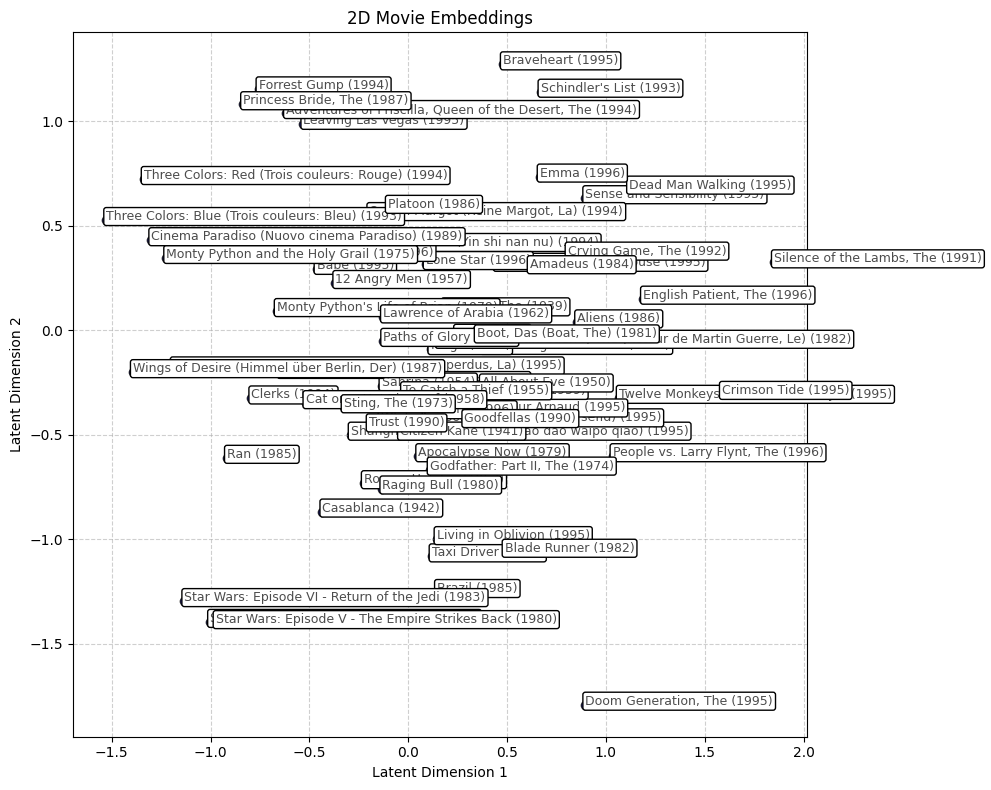

In [ ]:
movies_df = pd.read_csv('movies.csv')
movie_id_to_title = movies_df.set_index('movieId')['title'].to_dict()

selected_movie_indices = np.arange(70)
selected_movie_ids = [idx_to_movie[idx] for idx in selected_movie_indices]
selected_movie_titles = [movie_id_to_title[movie_id] for movie_id in selected_movie_ids]
selected_movie_vectors = movie_vectors[selected_movie_indices]

def plot_2d_embeddings(embeddings, labels, title="2D Movie Embeddings", save_path="movie_embeddings.pdf"):
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.8, c='blue', edgecolor='k')
    for i, label in enumerate(labels):
        plt.text(
            embeddings[i, 0], embeddings[i, 1], label,
            fontsize=9, alpha=0.7, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
        )
    plt.title(title)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()

plot_2d_embeddings(selected_movie_vectors, selected_movie_titles, save_path="2d_movie_embeddings.pdf")
